## Parameter Shifts
The goal is to shift the LSST datavectors in the $\Omega_m-A_s$ plane

In [49]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import getdist
from multiprocessing import Pool
from getdist import plots, MCSamples, WeightedSamples
%matplotlib inline

import sys
import os

sys.path.append(os.path.join(os.path.dirname("__file__"), '../LSST_emulation/'))
# LSST
from cocoa_emu import *
from cocoa_emu.emulator import NNEmulator, GPEmulator
from cocoa_emu.data_model import LSST_3x2

import emcee
import time

In [50]:
### LSST MCMC Functions

def plot_cosmo_contours(sample_list, legend_labels):
    names = ['logA', 'ns', 'H0', 'omegab', 'omegac']
    labels =  ['logA', 'ns', 'H0', 'omega b', 'omega c']
    
    cosmo_truth = [3.0675, 0.97, 69., 0.0228528, 0.1199772]
    
    truth_dict = {}
    for name, truth in zip(names, cosmo_truth):
        truth_dict[name] = truth
        
    getdist_samples = []
    for samples, legend_label in zip(sample_list, legend_labels):
        cosmo_samples = samples[:,:5]
        getdist_samples.append(MCSamples(samples=cosmo_samples,names = names, labels=labels, label=legend_label))
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(getdist_samples, filled=True, markers=truth_dict)
    
def add_bias(bias_theta, datavector):
    for i in range(5):
        factor = (bias_theta[i] / bias_fid[i])**bias_mask[i]
        datavector = factor * datavector
    return datavector

def add_shear_calib(m, datavector):
    for i in range(5):
        factor = (1 + m[i])**shear_calib_mask[i]
        datavector = factor * datavector
    return datavector

def hard_prior(theta, params_prior):
    """
    A function to impose a flat prior on a set of parameters.
    :theta: The set of parameter values
    :params_prior: The minimum and the maximum value of the parameters on which this prior is imposed
    """
    is_lower_than_min = bool(np.sum(theta < params_prior[:,0]))
    is_higher_than_max = bool(np.sum(theta > params_prior[:,1]))
    if is_lower_than_min or is_higher_than_max:
        return -np.inf
    else:
        return 0.
    
cosmo_prior_lim = np.array([[1.61, 3.91],# planck [1.61,  3.91,  'uniform'],
                       [0.87, 1.07], # planck [0.9,   1.1,   'uniform']
                       [55, 91],
                       [0.01, 0.04], # [0.001, 0.04, 'uniform'],
                       [0.001, 0.99]]) # [0.005, 0.99,  'uniform'],

# parameters of the analysis, and their priors

ia_prior_lim = np.array([[-5., 5.],
                       [-5., 5.]])

bias_prior_lim = np.array([[0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.]])

baryon_prior_lim = np.array([[-3., 12.],
                             [-2.5, 2.5]])

baryon_prior_lim = 3. * baryon_prior_lim 

dz_source_std   = 0.002 * np.ones(5)
dz_lens_std     = 0.005 * np.ones(5)
shear_calib_std = 0.005 * np.ones(5)
    
def lnprior(theta):
    cosmo_theta = theta[:5]
    ns          = cosmo_theta[1]

    ns_prior    = 0.
    
    dz_source   = theta[5:10]
    ia_theta    = theta[10:12]
    dz_lens     = theta[12:17]
    bias        = theta[17:22]
    shear_calib = theta[22:27]
    baryon_q    = theta[27:29]
    
    cosmo_prior = hard_prior(cosmo_theta, cosmo_prior_lim) + ns_prior
    ia_prior    = hard_prior(ia_theta, ia_prior_lim)
    bias_prior  = hard_prior(bias, bias_prior_lim)
    baryon_prior = hard_prior(baryon_q, baryon_prior_lim)
    
    dz_source_lnprior   = -0.5 * np.sum((dz_source / dz_source_std)**2)
    dz_lens_lnprior     = -0.5 * np.sum((dz_lens / dz_lens_std)**2)
    shear_calib_lnprior = -0.5 * np.sum((shear_calib / shear_calib_std)**2)
    
    return cosmo_prior + ia_prior + dz_source_lnprior + dz_lens_lnprior + \
            shear_calib_lnprior + bias_prior + baryon_prior
    
def ln_lkl(theta):
    model_datavector = get_data_vector_emu(theta)[0]
    delta_dv = (model_datavector - data_model.dv_obs)[data_model.mask_3x2]
    return -0.5 * delta_dv @ data_model.masked_inv_cov @ delta_dv

def lnprob(theta):
    return lnprior(theta) + ln_lkl(theta)

def get_data_vector_emu(theta):
    """
    Function to get the emulated data vector (including the effect of galaxy bias, baryons, etc.)
    """
    cosmo_ia_dz_theta = theta[:17]
    bias        = theta[17:22]
    shear_calib = theta[22:27]
    baryon_q    = theta[27:29]
    datavector = data_model.compute_datavector(cosmo_ia_dz_theta)
    datavector = np.array(datavector)
    datavector = add_bias(bias, datavector)
    datavector = add_shear_calib(shear_calib, datavector)
    return datavector

In [51]:
# open the emulator
# Get the LSST covariance and fid data
path = '/home/grads/data/evan/LSST_emulation/data/lsst_y1/'
lsst_cov = np.loadtxt(path+'cov_lsst_y1')
fid_cos = np.loadtxt(path+'lsst_y1_data_fid',dtype=np.float32)[:,1]

lsst_y1_cov = np.zeros((1560, 1560))
for line in lsst_cov:
    i = int(line[0])
    j = int(line[1])

    cov_g_block  = line[-2]
    cov_ng_block = line[-1]

    cov_ij = cov_g_block + cov_ng_block

    lsst_y1_cov[i,j] = cov_ij
    lsst_y1_cov[j,i] = cov_ij
    
fid = torch.Tensor(fid_cos)
cov = torch.Tensor(lsst_y1_cov)

configfile = path+'../../configs/nn_emu.yaml'
config = Config(configfile)

config_args     = config.config_args
config_args_io  = config_args['io']
config_args_data = config_args['data']

savedir = path+'../../output/nn_emu/'

N_DIM         = 17
data_model    = LSST_3x2(N_DIM, config_args_io, config_args_data)
data_model.emu_type = 'nn'
OUTPUT_DIM = 1560

emu = NNEmulator(N_DIM, OUTPUT_DIM, data_model.dv_fid, data_model.dv_std)    
emu.load(path+'../../model/nn_emu/model')
# ======================================================

data_model.emu = emu

bias_fid         = data_model.bias_fid
bias_mask        = data_model.bias_mask
shear_calib_mask = data_model.shear_calib_mask

N_MCMC        = 5000
N_WALKERS     = 120
NDIM_SAMPLING = 32

theta0    = np.array([3.0675, 0.97, 69.0, 0.0228528, 0.1199772, 
                      0., 0., 0., 0., 0.,
                      0.5, 0.,
                      0., 0., 0., 0., 0.,
                      1.24, 1.36, 1.47, 1.60, 1.76,
                      0., 0., 0., 0., 0.,
                      0., 0.,1.05,0.05,1.0])

theta_std = np.array([0.01, 0.001, 0.1, 0.001, 0.002, 
                      0.002, 0.002, 0.002, 0.002, 0.002, 
                      0.1, 0.1,
                      0.005, 0.005, 0.005, 0.005, 0.005, 
                      0.03, 0.03, 0.03, 0.03, 0.03,
                      0.005, 0.005, 0.005, 0.005, 0.005, 
                      0.1, 0.1,0.01,0.01,0.01]) 

# Starting position of the emcee chain
pos0 = theta0[np.newaxis] + 3. * theta_std[np.newaxis] * np.random.normal(size=(N_WALKERS, NDIM_SAMPLING))

In [52]:
with Pool(10) as pool:
    emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
    emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:51<00:00, 14.23it/s]


In [53]:
N_BURN_IN = 1500
N_THIN    = 10

In [54]:
samples = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))

Removed no burn in


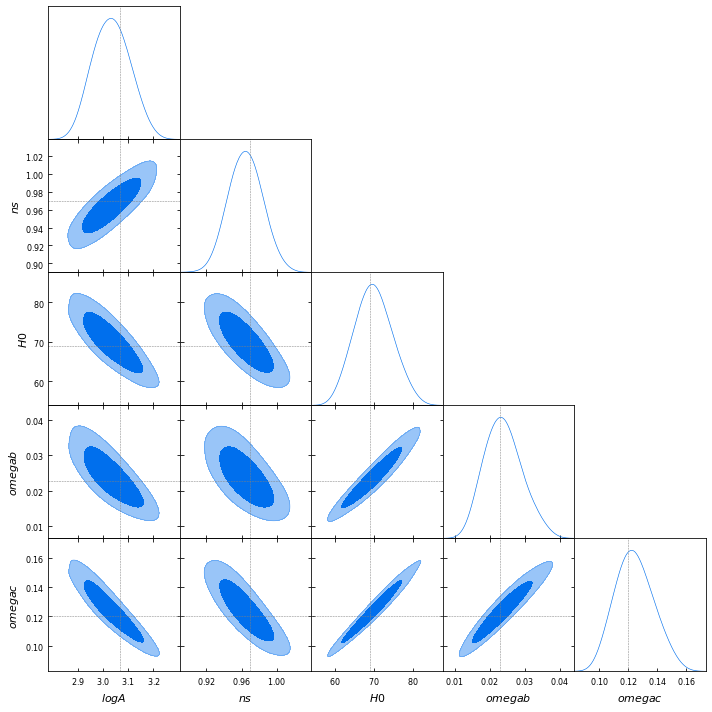

In [55]:
plot_cosmo_contours([samples], ['Fiducial scalecut'])

In [56]:
names = ['logA', 'ns', 'H0', 'omegab', 'omegac']
labels =  ['logA', 'ns', 'H0', 'omega b', 'omega c']

chain = MCSamples(samples=samples[...,:5],names=names,labels=labels)

stdev_oc = np.sqrt(chain.cov(['omegac'])[0][0])
stdev_as = np.sqrt(chain.cov(['logA'])[0][0])
print(stdev_oc)
print(stdev_as)


Removed no burn in
0.01353435381480063
0.07510647690935982


## Reparameterization
Convert to $(\sigma_8,n_s,H_0,\Omega_b,\Omega_m)$

In [57]:
# reparameterize
def emu_to_params(theta,means=None):
    logAs = theta[:,0]
    ns    = theta[:,1]
    H0    = theta[:,2]
    ombh2 = theta[:,3]
    omch2 = theta[:,4]
    
    omnh2 = (3.046/3)**(3/4)*0.06/94.1
    
    h = H0/100
    As = np.exp(logAs)/(10**10)
    
    omb = ombh2/(h**2)
    omc = omch2/(h**2)
    omn = omnh2/(h**2)
    
    omm = omb+omc+omn
    ommh2 = omm*(h**2)
    
    sigma_8 = (As/3.135e-9)**(1/2) * \
              (ombh2/0.024)**(-0.272) * \
              (ommh2/0.14)**(0.513) * \
              (3.123*h)**((ns-1)/2) * \
              (h/0.72)**(0.698) * \
              (omm/0.27)**(0.236) * \
              (1-0.014)
        
    return np.transpose(np.array([sigma_8,ns,H0,omb,omm]))
                

def params_to_emu(theta):
    sigma8 = theta[:,0]
    ns = theta[:,1]
    H0 = theta[:,2]
    ob = theta[:,3]
    om = theta[:,4]
    
    h = H0/100
    omnh2 = (3.046/3)**(3/4)*0.06/94.1
    on = omnh2/(h**2)
    
    oc = om-ob-on
    obh2 = ob*(h**2)
    och2 = oc*(h**2)
    omh2 = om*(h**2)
    
    step =  (sigma8/(1-0.014)) * \
            (obh2/0.024)**(0.272) * \
            (omh2/0.14)**(-0.513) * \
            (3.123*h)**(-(ns-1)/2) * \
            (h/0.72)**(-0.698) * \
            (om/0.27)**(-0.236)
    As = (step**2)*3.135e-9
    logAs = np.log(As*(10**10))
    
    return np.transpose(np.array([logAs,ns,H0,obh2,och2]))

[[3.067500e+00 9.700000e-01 6.900000e+01 2.285280e-02 1.199772e-01]]
[[8.25018076e-01 9.70000000e-01 6.90000000e+01 4.80000000e-02
  3.01354628e-01]]
[[3.067500e+00 9.700000e-01 6.900000e+01 2.285280e-02 1.199772e-01]]
Removed no burn in


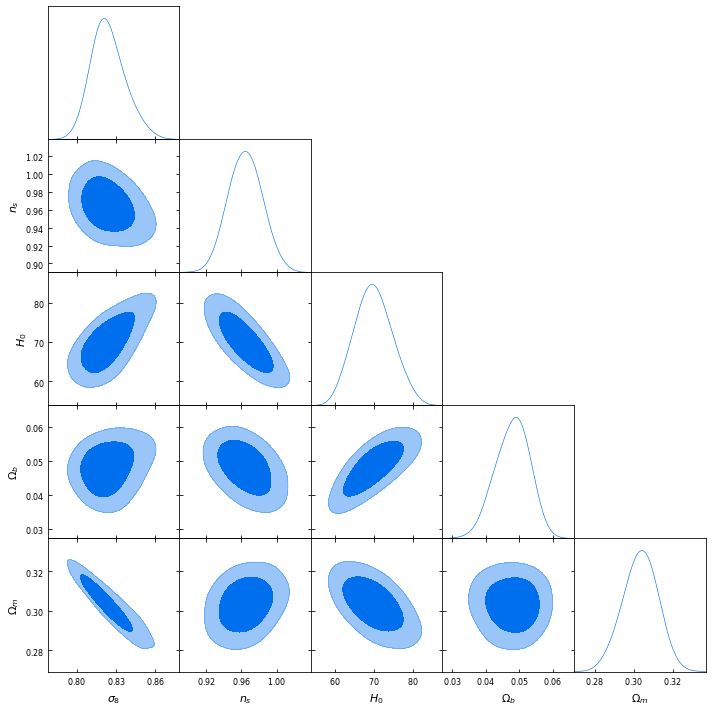

In [58]:
#test
truth = [3.0675, 0.97, 69., 0.0228528, 0.1199772]
truth_converted = emu_to_params(np.array([truth]))
print(np.array([truth]))
print(truth_converted)
print(params_to_emu(truth_converted))

converted_samples = emu_to_params(samples)
names = ['sigma8','ns','H0','Omegab','omegam']
labels = ['\sigma_8','n_s','H_0','\Omega_b','\Omega_m']
re_chain = MCSamples(samples=converted_samples,names=names,labels=labels)
g = plots.get_subplot_plotter()
g.triangle_plot(re_chain, filled=True)

In [69]:
# generate shifts in $\sigma_8$
var = re_chain.cov(['sigma8'])[0][0]
print(var)
stdev = np.sqrt(var)
re_truth = truth_converted[0]
data_vectors = []
vals = []

for i in range(0,11):
    params = re_truth - (i-5)*stdev*np.array([1.,0.,0.,0.,0.]) # shift     
    cosmo_params = list(params_to_emu(np.array([params])))         # convert to emu params
    cosmo_params.append( [0., 0., 0., 0., 0.,
                      0.5, 0.,
                      0., 0., 0., 0., 0.,
                      1.24, 1.36, 1.47, 1.60, 1.76,
                      0., 0., 0., 0., 0.,
                      0., 0.,1.05,0.05,1.0])               # add systematics
    cosmo_params = [item for sublist in cosmo_params for item in sublist] # concatenate
    dv = get_data_vector_emu(np.array(cosmo_params))      #get datavector
    vals.append(params[0])
    print('log_lkl={:.5f}, shift={}sigma, sigma8={:.5f}'.format(-2*ln_lkl(np.array(cosmo_params)),(i-5),params[0]))
    data_vectors.append(dv)

0.00018400970432105618
log_lkl=4409.29731, shift=-5sigma, sigma8=0.89284
log_lkl=3546.57662, shift=-4sigma, sigma8=0.87928
log_lkl=2764.58589, shift=-3sigma, sigma8=0.86571
log_lkl=2078.71033, shift=-2sigma, sigma8=0.85215
log_lkl=1482.29687, shift=-1sigma, sigma8=0.83858
log_lkl=985.62342, shift=0sigma, sigma8=0.82502
log_lkl=585.44075, shift=1sigma, sigma8=0.81145
log_lkl=287.91564, shift=2sigma, sigma8=0.79789
log_lkl=94.76806, shift=3sigma, sigma8=0.78432
log_lkl=8.89656, shift=4sigma, sigma8=0.77076
log_lkl=-0.00000, shift=5sigma, sigma8=0.75719


In [42]:
# now lets sample
shifted_samples = []

for dv in data_vectors:
    data_model.dv_obs = dv[0]
    emu_sampler = None
    with Pool(10) as pool:
        emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
        emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)
    _samples = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))
    _s = _samples[...,:5]
    shifted_samples.append(_s)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [05:52<00:00, 14.18it/s]


(11, 42000, 5)
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


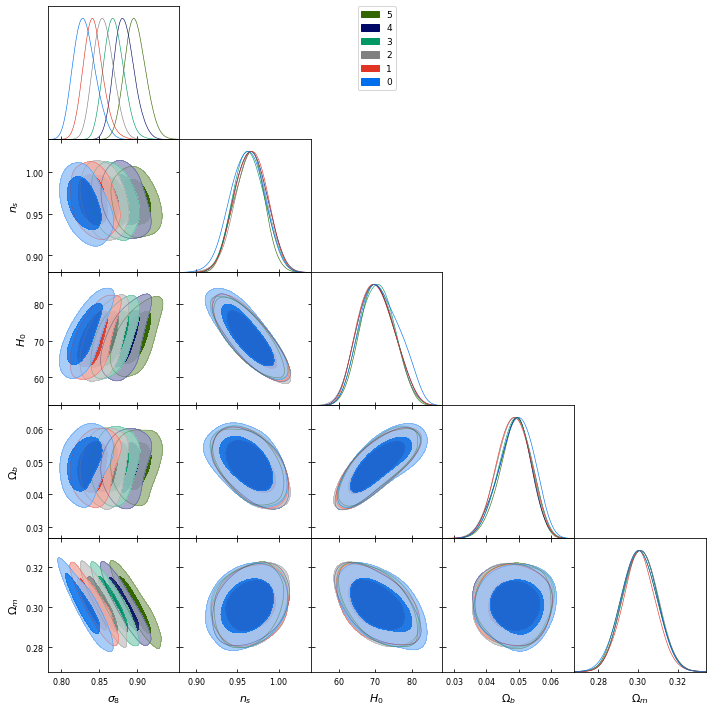

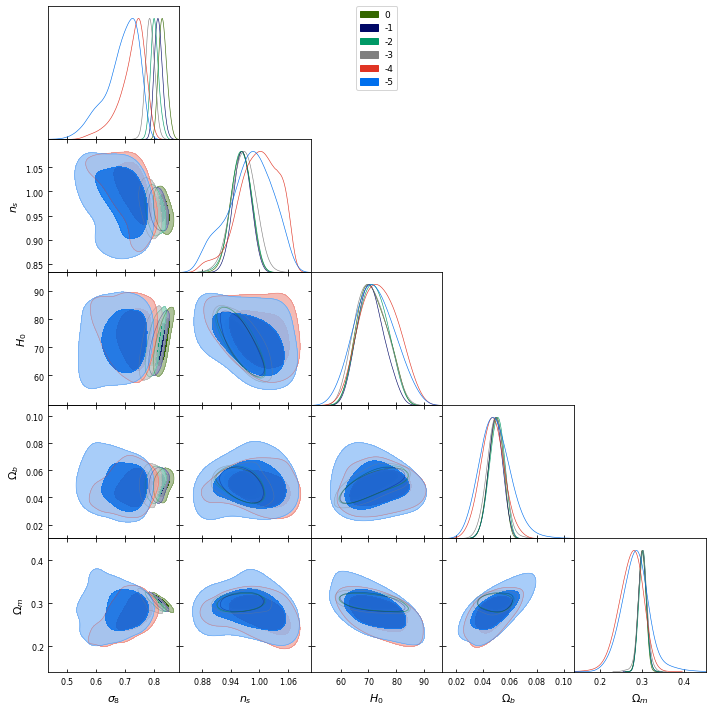

In [44]:
def plot_cosmo_contours(sample_list, legend_labels):
    names = ['sigma8','ns','H0','Omegab','omegam']
    labels = ['\sigma_8','n_s','H_0','\Omega_b','\Omega_m']
    
    cosmo_truth = [3.0675, 0.97, 69., 0.0228528, 0.1199772]
    
    truth_dict = {}
    for name, truth in zip(names, cosmo_truth):
        truth_dict[name] = truth
        
    getdist_samples = []
    for samples, legend_label in zip(sample_list, legend_labels):
        cosmo_samples = emu_to_params(samples[:,:5])
        getdist_samples.append(MCSamples(samples=cosmo_samples,names = names, labels=labels, label=legend_label))
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(getdist_samples, filled=True)#, markers=truth_dict)

plot_cosmo_contours(shifted_samples[:6],
                    ['5','4','3','2','1','0'])
plot_cosmo_contours(shifted_samples[5:],
                    ['0','-1','-2','-3','-4','-5'])


In [70]:
# generate shifts in $\Omega_m$
var = re_chain.cov(['omegam'])[0][0]
print(var)
stdev = np.sqrt(var)
print(truth_converted)
re_truth = truth_converted[0]
data_vectors = []
vals = []

for i in range(0,11):
    params = re_truth - (i-5)*stdev*np.array([0.,0.,0.,0.,1.]) # shift     
    cosmo_params = list(params_to_emu(np.array([params])))         # convert to emu params
    cosmo_params.append( [0., 0., 0., 0., 0.,
                      0.5, 0.,
                      0., 0., 0., 0., 0.,
                      1.24, 1.36, 1.47, 1.60, 1.76,
                      0., 0., 0., 0., 0.,
                      0., 0.,1.05,0.05,1.0])               # add systematics
    cosmo_params = [item for sublist in cosmo_params for item in sublist] # concatenate
    dv = get_data_vector_emu(np.array(cosmo_params))      #get datavector
    vals.append(params[4])
    print('log_lkl={:.5f}, shift={}sigma, omegam={:.5f}'.format(-2*ln_lkl(np.array(cosmo_params)),(i-5),params[4]))
    data_vectors.append(dv)

8.021843990167796e-05
[[8.25018076e-01 9.70000000e-01 6.90000000e+01 4.80000000e-02
  3.01354628e-01]]
log_lkl=3216.32797, shift=-5sigma, omegam=0.34614
log_lkl=2764.06690, shift=-4sigma, omegam=0.33718
log_lkl=2243.28997, shift=-3sigma, omegam=0.32822
log_lkl=1720.36993, shift=-2sigma, omegam=0.31927
log_lkl=1318.79110, shift=-1sigma, omegam=0.31031
log_lkl=985.62342, shift=0sigma, omegam=0.30135
log_lkl=732.95402, shift=1sigma, omegam=0.29240
log_lkl=628.00002, shift=2sigma, omegam=0.28344
log_lkl=597.96319, shift=3sigma, omegam=0.27449
log_lkl=643.24541, shift=4sigma, omegam=0.26553
log_lkl=739.43626, shift=5sigma, omegam=0.25657


In [36]:
# now lets sample
shifted_samples = []

for dv in data_vectors:
    data_model.dv_obs = dv[0]
    emu_sampler = None
    with Pool(10) as pool:
        emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
        emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)
    _samples = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))
    _s = _samples[...,:5]
    shifted_samples.append(_s)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [06:00<00:00, 13.87it/s]


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


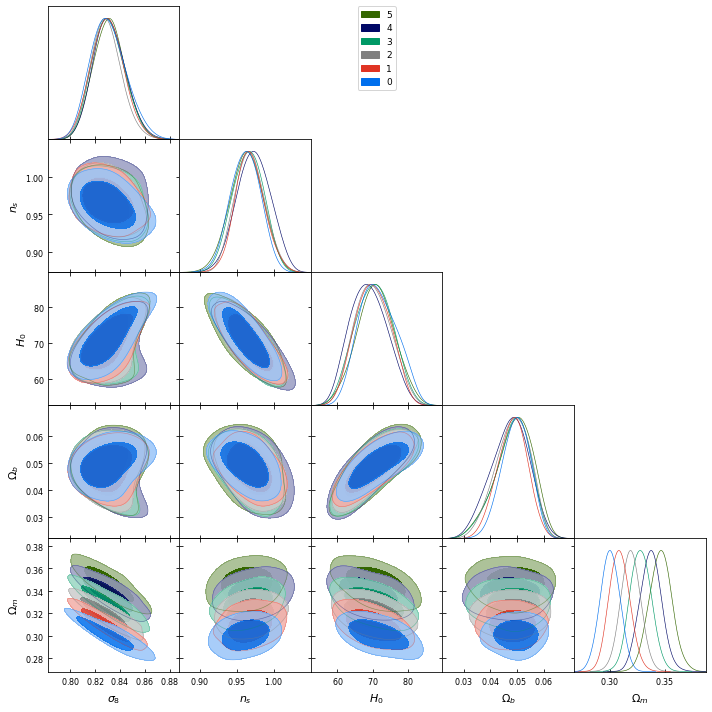

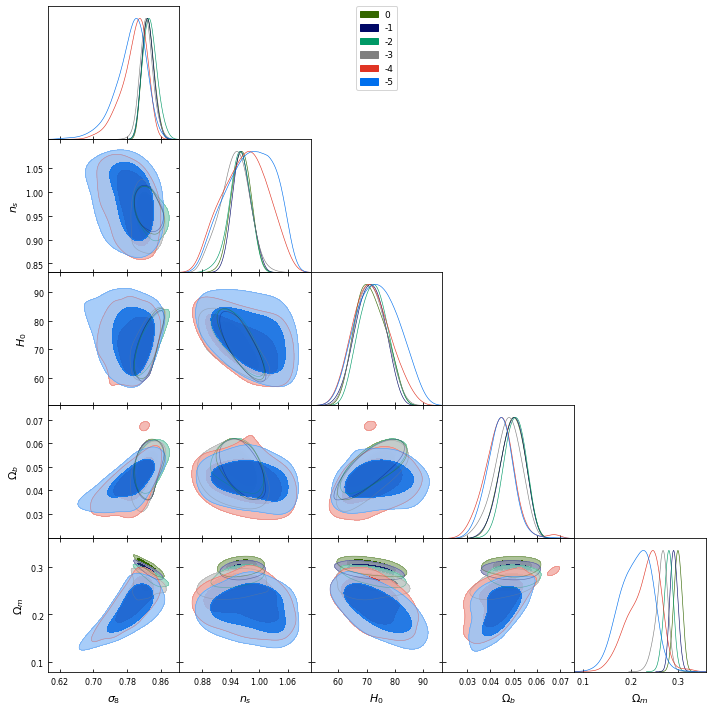

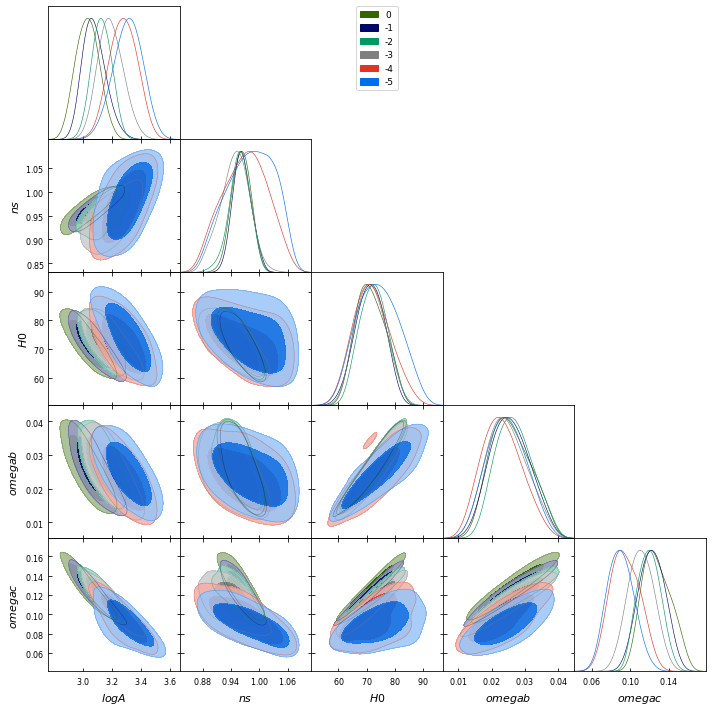

In [40]:
def plot_cosmo_contours(sample_list, legend_labels):
    names = ['sigma8','ns','H0','Omegab','omegam']
    labels = ['\sigma_8','n_s','H_0','\Omega_b','\Omega_m']
        
    getdist_samples = []
    for samples, legend_label in zip(sample_list, legend_labels):
        cosmo_samples = emu_to_params(samples[:,:5])
        getdist_samples.append(MCSamples(samples=cosmo_samples,names = names, labels=labels, label=legend_label))
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(getdist_samples, filled=True)

plot_cosmo_contours(shifted_samples[:6],
                    ['5','4','3','2','1','0'])
plot_cosmo_contours(shifted_samples[5:],
                    ['0','-1','-2','-3','-4','-5'])

def plot_cosmo_contours(sample_list, legend_labels):
    names = ['logA', 'ns', 'H0', 'omegab', 'omegac']
    labels =  ['logA', 'ns', 'H0', 'omega b', 'omega c']
        
    getdist_samples = []
    for samples, legend_label in zip(sample_list, legend_labels):
        cosmo_samples = samples[:,:5]
        getdist_samples.append(MCSamples(samples=cosmo_samples,names = names, labels=labels, label=legend_label))
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(getdist_samples, filled=True)

plot_cosmo_contours(shifted_samples[5:],
                    ['0','-1','-2','-3','-4','-5'])

## PCA
generate shifts along the 3 most constraining principle components.

In [24]:
# Create log chains
def log_samples(theta):
    log_sigma8 = np.log(theta[:,0])#/means[0])
    log_ns     = np.log(theta[:,1])#/means[1])
    log_H0     = np.log(theta[:,2])#/means[2])
    log_omegab = np.log(theta[:,3])#/means[3])
    log_omegam = np.log(theta[:,4])#/means[4])
    
    return np.transpose(np.array([log_sigma8,log_ns,log_H0,log_omegab,log_omegam]))
    
def exp_samples(theta):
    sigma8 = np.exp(theta[:,0])#*means[0]
    ns     = np.exp(theta[:,1])#*means[1]
    H0     = np.exp(theta[:,2])#*means[2]
    omegab = np.exp(theta[:,3])#*means[3]
    omegam = np.exp(theta[:,4])#*means[4]
    
    return np.transpose(np.array([sigma8,ns,H0,omegab,omegam]))

In [33]:
m_sigma8 = np.mean(converted_samples[:,0])
m_ns     = np.mean(converted_samples[:,1])
m_H0     = np.mean(converted_samples[:,2])
m_omegab = np.mean(converted_samples[:,3])
m_omegam = np.mean(converted_samples[:,4])

means = np.array([m_sigma8,m_ns,m_H0,m_omegab,m_omegam])
log_s = log_samples(converted_samples)

names = ['logsigma8','logns','logH0','logOmegab','logOmegam']
#print(log_s)
log_chain = MCSamples(samples=log_s,names=names,labels=names)

cov = log_chain.cov(['logns','logH0','logOmegab'])
evals,evecs = np.linalg.eig(cov)
PC_cov = np.linalg.inv(evecs) @ cov @ evecs
print('variances:')
print(PC_cov)
print('')
print('eigenvalues')
print(evals)
print('')
print('eigenvectors')
print(evecs)

sorted_evals = np.sort(evals) #sort

idxs = [] # to go from params to PC
sorted_idxs = [] #go from PC to params

for e in sorted_evals:
    idx = np.where(evals==e)
    idxs.append(idx[0][0])
    
print(idxs)

Removed no burn in
variances:
[[ 1.58861073e-02  3.25260652e-19  8.67361738e-19]
 [-3.73880343e-18  1.25768334e-04  2.66815378e-19]
 [ 5.31259065e-18  4.87890978e-19  1.94363134e-03]]

eigenvalues
[0.01588611 0.00012577 0.00194363]

eigenvectors
[[-0.09719153  0.94969979  0.29769802]
 [ 0.48640417  0.30628428 -0.81829146]
 [ 0.86831146 -0.06527056  0.49170618]]
[1, 2, 0]


In [34]:
# shift along most constraining PC
pc = idxs[0]
data_vectors = []
vals = []

subtract_arr = np.zeros(3)
subtract_arr[pc] = np.sqrt(PC_cov[pc][pc])

truth_eb = np.linalg.inv(evecs) @ np.log(truth_converted[0][1:4])

for i in range(0,11):
    params = [list(truth_eb - (i-5)*subtract_arr)]   #shift
    vals.append(truth_eb[pc]- (i-5)*np.sqrt(PC_cov[pc][pc])) #record value
    params = np.array([evecs @ params[0]]) # turn back to log basis
    params = np.array([[truth_converted[0][0],
               params[0][0],params[0][1],params[0][2],
              truth_converted[0][4]]]) # add in the two remaining params that were marginalized
    exp_params = exp_samples(params) # exponentiate
    exp_params[0][0] = truth_converted[0][0] # reset sigma8
    exp_params[0][4] = truth_converted[0][4] # reset omegam
    cosmo_params = list(params_to_emu(exp_params))
    print(cosmo_params)
    cosmo_params.append( [0., 0., 0., 0., 0.,
                      0.5, 0.,
                      0., 0., 0., 0., 0.,
                      1.24, 1.36, 1.47, 1.60, 1.76,
                      0., 0., 0., 0., 0.,
                      0., 0.,1.05,0.05,1.0])
    cosmo_params = [item for sublist in cosmo_params for item in sublist]
    dv = get_data_vector_emu(np.array(cosmo_params))
    print('log_lkl={:.5f}, shift={}sigma'.format(-2*ln_lkl(np.array(cosmo_params)),(i-5)))
    data_vectors.append(dv)

[array([2.98384940e+00, 1.02305530e+00, 7.01952649e+01, 2.35649967e-02,
       1.24278797e-01])]
log_lkl=137.39140, shift=-5sigma
[array([3.00090288e+00, 1.01221701e+00, 6.99545668e+01, 2.34208035e-02,
       1.23406407e-01])]
log_lkl=91.79348, shift=-4sigma
[array([3.01779257e+00, 1.00149355e+00, 6.97146942e+01, 2.32774926e-02,
       1.22540094e-01])]
log_lkl=57.19385, shift=-3sigma
[array([3.03452059e+00, 9.90883698e-01, 6.94756440e+01, 2.31350586e-02,
       1.21679817e-01])]
log_lkl=30.57546, shift=-2sigma
[array([3.05108904e+00, 9.80386244e-01, 6.92374136e+01, 2.29934962e-02,
       1.20825533e-01])]
log_lkl=14.66244, shift=-1sigma
[array([3.067500e+00, 9.700000e-01, 6.900000e+01, 2.285280e-02,
       1.199772e-01])]
log_lkl=8.38613, shift=0sigma
[array([3.08375551e+00, 9.59723788e-01, 6.87634005e+01, 2.27129647e-02,
       1.19134777e-01])]
log_lkl=12.33235, shift=1sigma
[array([3.09985760e+00, 9.49556443e-01, 6.85276123e+01, 2.25739850e-02,
       1.18298224e-01])]
log_lkl=27.6

In [35]:
# now lets sample
shifted_samples_PC0 = []

for dv in data_vectors:
    data_model.dv_obs = dv[0]
    emu_sampler = None
    with Pool(10) as pool:
        emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
        emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)
    _samples = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))
    _s = _samples[...,:5]
    shifted_samples_PC0.append(_s)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [06:05<00:00, 13.68it/s]


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


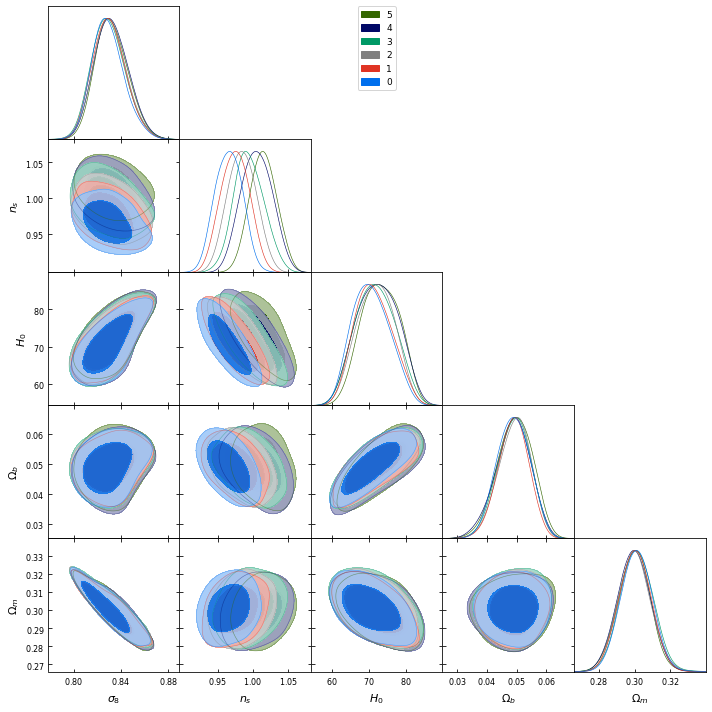

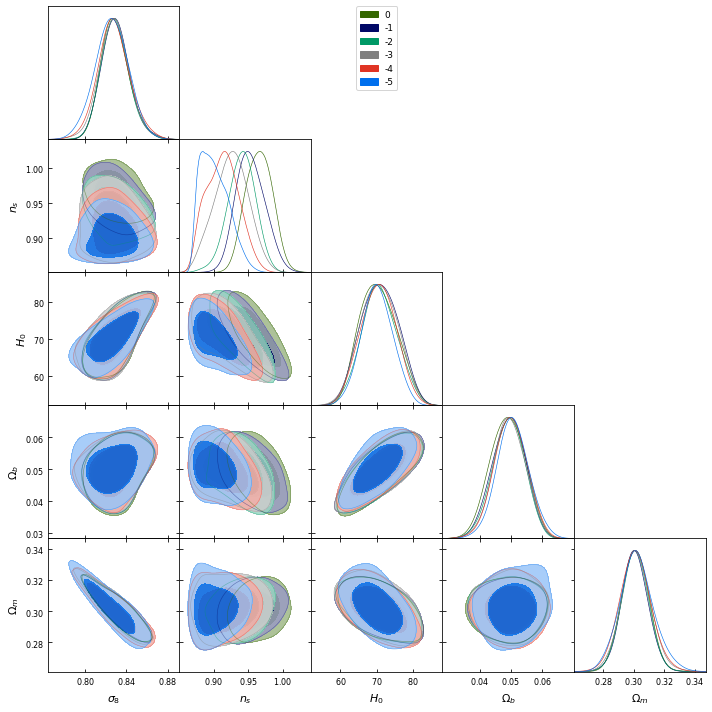

In [36]:
def plot_cosmo_contours(sample_list, legend_labels):
    names = ['sigma8','ns','H0','Omegab','omegam']
    labels = ['\sigma_8','n_s','H_0','\Omega_b','\Omega_m']
        
    getdist_samples = []
    for samples, legend_label in zip(sample_list, legend_labels):
        cosmo_samples = emu_to_params(samples[:,:5])
        getdist_samples.append(MCSamples(samples=cosmo_samples,names = names, labels=labels, label=legend_label))
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(getdist_samples, filled=True)

plot_cosmo_contours(shifted_samples_PC0[:6],
                    ['5','4','3','2','1','0'])
plot_cosmo_contours(shifted_samples_PC0[5:],
                    ['0','-1','-2','-3','-4','-5'])
                     

## Adding Planck Variance
In the DES paper, they approximated the full injected error as the sum-of-squares error between Planck and DES. Here I will do the same with Planck and LSST.

In [62]:
lsst_path    = '/home/grads/extra_data/evan/lsst_chains/'
planck_path  = '/home/grads/extra_data/evan/planck_chains/'

i=3
chain1 = getdist.mcsamples.loadMCSamples(planck_path+str(i))
chain2 = getdist.mcsamples.loadMCSamples(lsst_path+'lsst_'+str(i))

chain1.removeBurnFraction(0.5) # forgot :(
chain1.weighted_thin(10)       #forgot

Removed no burn in
Removed no burn in


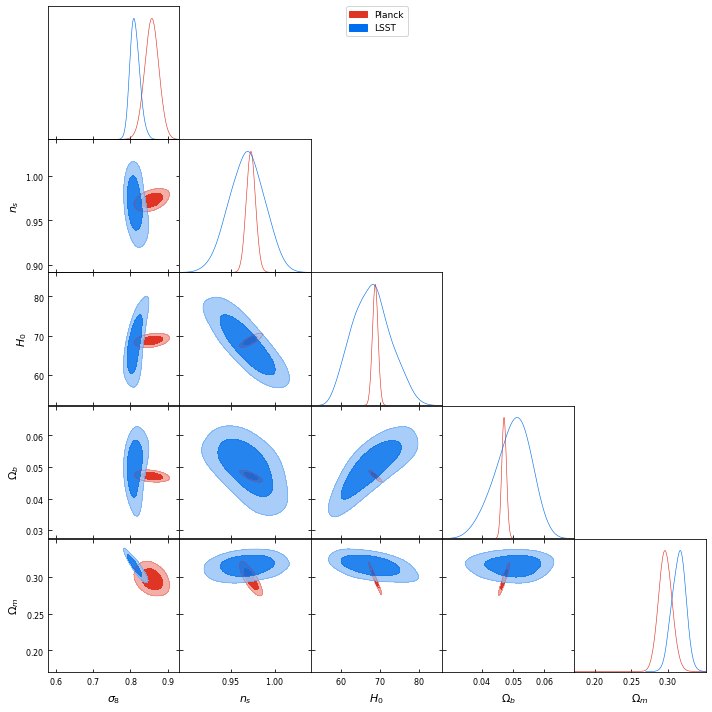

In [68]:
names = ['sigma8','ns','H0','omegab','omegam']
labels = ['\sigma_8','n_s','H_0','\Omega_b','\Omega_m']

rel_params1 = chain1.samples[:,[5,4,2,0,1]]
rel_params1[:,2] = 100*rel_params1[:,2] # h->H0
re_chain1 = getdist.mcsamples.MCSamples(samples=emu_to_params(rel_params1),names=names,labels=labels)
re_chain2 = getdist.mcsamples.MCSamples(samples=emu_to_params(chain2.samples),names=names,labels=labels)

g = plots.get_subplot_plotter()
g.triangle_plot([re_chain1,re_chain2], legend_labels=['Planck','LSST'], filled=True)

In [71]:
planck_var_s8 = re_chain1.cov(['sigma8'])[0][0]
lsst_var_s8   = re_chain2.cov(['sigma8'])[0][0]

print(planck_var_s8)
print(lsst_var_s8)

var_sigma8 = np.sqrt(planck_var_s8**2 + lsst_var_s8**2)

print(var_sigma8)

0.0005821580604487092
0.00017785299077026142
0.0006087197168412813


## Tension-Invariance under reparameterizations
Some metrics rely on gaussianity to be accurate. However reparameterizations that are not a linear transformation of $(\log{A_s},n_s,H_0,\Omega_bh^2,\Omega_ch^2)$ may affect gaussianity. Thus I want to see how the $\sigma_8-\Omega_m-\Omega_b$ reparameterizations affects the tension results. 

In [73]:
sys.path.append(os.path.join(os.path.dirname("__file__"), '../tension_calibration/'))
from metrics import diff
from metrics import flow
from metrics import tension
from metrics.parameter_metrics import *
from metrics import utilities
from emulators import lsst
from emulators import cosmopower

In [4]:
lsst_path    = '/home/grads/extra_data/evan/lsst_chains/'
planck_path  = '/home/grads/extra_data/evan/planck_chains/'
joint_path = '/home/grads/extra_data/evan/joint_chains/'

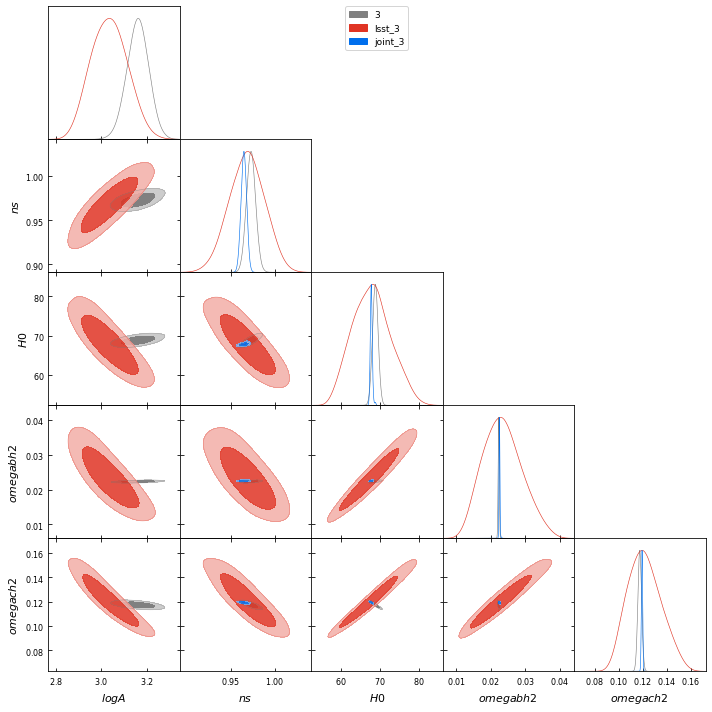

In [87]:
i=3
chain1 = getdist.mcsamples.loadMCSamples(planck_path+str(i))
chain2 = getdist.mcsamples.loadMCSamples(lsst_path+'lsst_'+str(i))
chain3 = getdist.mcsamples.loadMCSamples(joint_path+'joint_'+str(i))
chain1.removeBurnFraction(0.5) # forgot :(
chain1.weighted_thin(10)       #forgot
s = chain1.samples
s[...,2] = 100*s[...,2] #h->H0
chain1.setSamples(s)

g = plots.get_subplot_plotter()
g.triangle_plot([chain1,chain2,chain3], params=['logA','ns','H0','omegabh2','omegach2'], filled=True)

In [89]:
names = ['sigma8','ns','H0','omegab','omegam']
labels = ['\sigma_8','n_s','H_0','\Omega_b','\Omega_m']

rel_params1 = chain1.samples[:,[5,4,2,0,1]]
rel_params3 = chain3.samples[:,[2,3,4,0,1]]

print(rel_params1[1000])
print(chain2.samples[1000])
print(rel_params3[1000])
re_chain1 = getdist.mcsamples.MCSamples(samples=emu_to_params(rel_params1),names=names,labels=labels)
re_chain2 = getdist.mcsamples.MCSamples(samples=emu_to_params(chain2.samples),names=names,labels=labels)
re_chain3 = getdist.mcsamples.MCSamples(samples=emu_to_params(rel_params3),names=names,labels=labels)

[3.13101816e+00 9.68304694e-01 6.80468321e+01 2.22321786e-02
 1.18855521e-01]
[2.95530413e+00 9.35824571e-01 7.48712568e+01 2.87276738e-02
 1.39568090e-01]
[3.06230973e+00 9.67328417e-01 6.77149485e+01 2.24605623e-02
 1.19320554e-01]
Removed no burn in
Removed no burn in
Removed no burn in


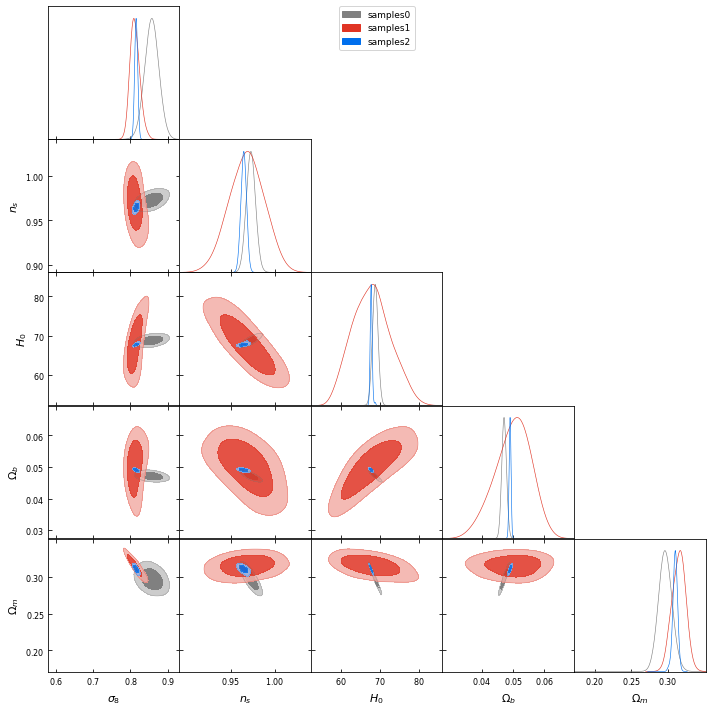

In [90]:
g = plots.get_subplot_plotter()
g.triangle_plot([re_chain1,re_chain2,re_chain3], filled=True)

In [94]:
#standard LCDM
results1 = []

chains = diff.chain()
chains.chains = [chain1,chain2]     
chains.diff(feedback=False) # compute the difference chain

maf = flow.MAF(len(chains.params))
maf.setup(feedback=False)

for i in range(20):
    maf.train(chains.diff_chain,batch_size=10000,feedback=False)
    nsigma,high,low = tension.flow_significance(
                            maf.target_dist,
                            maf.gauss_bijector,
                            len(chains.params)
                            )
    results1.append(nsigma)
    
results1 = np.array(results1)
print('\nLCDM')
print(np.mean(results1))
print(np.std(results1))
print('\n')
        
#reparameterization
results2 = []

chains = diff.chain()
chains.chains = [re_chain1,re_chain2]     
chains.diff(feedback=False) # compute the difference chain

maf = flow.MAF(len(chains.params))
maf.setup(feedback=False)

for i in range(20):
    maf.train(chains.diff_chain,batch_size=10000,feedback=False)
    nsigma,high,low = tension.flow_significance(
                            maf.target_dist,
                            maf.gauss_bijector,
                            len(chains.params)
                            )
    results2.append(nsigma)
    
results2 = np.array(results2)
print('\nreparameterized')
print(np.mean(results2))
print(np.std(results2))

[####################] Completed!                             
[####################] Completed!                             
[####################] Completed!                             
[####################] Completed!                             
[####################] Completed!                             
[####################] Completed!                             
[####################] Completed!                             
[####################] Completed!                             
[####################] Completed!                             
[####################] Completed!                             
[####################] Completed!                             
[####################] Completed!                             
[####################] Completed!                             
[####################] Completed!                             
[####################] Completed!                             
[####################] Completed!                      

In [98]:
print('LCDM')
print(np.mean(results1))
print(np.std(results1))
print('\nreparameterized')
print(np.mean(results2))
print(np.std(results2))

LCDM
0.7851297192961985
0.061902199082101546

reparameterized
0.7522378994311323
0.013278130407785364


## Noise Realizations

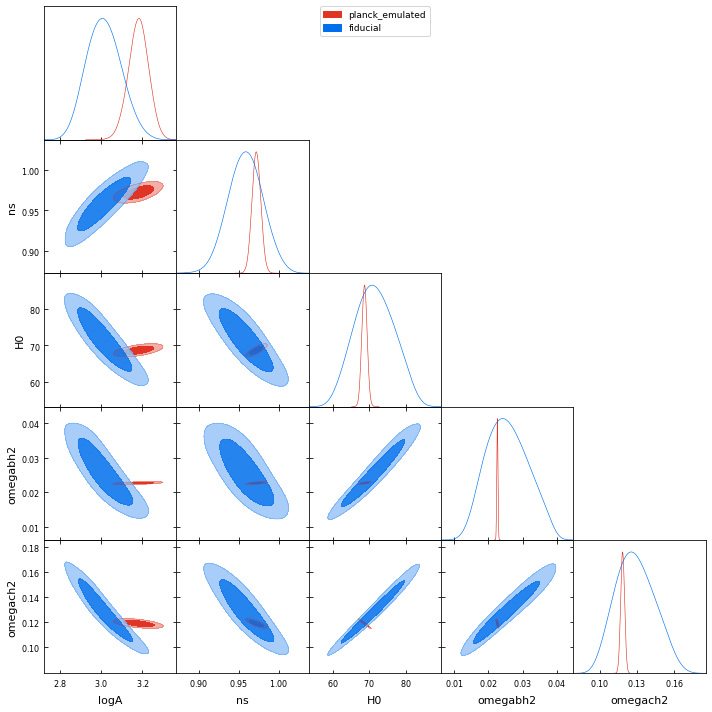

In [19]:
#open fiducial
lsst_path    = '/home/grads/data/evan/mc_data/fiducial'
planck_path  = '/home/grads/data/evan/cosmopower_emcee/notebooks/planck_emulated'

chain1 = getdist.mcsamples.loadMCSamples(planck_path)
chain2 = getdist.mcsamples.loadMCSamples(lsst_path)

#chain1.removeBurnFraction(0.5) # forgot :(
#chain1.weighted_thin(10)       #forgot

names = chain1.getParamNames().getRunningNames()
names[0]='omegabh2'
names[1]='omegach2'
names[2]='H0'

names2 = chain2.getParamNames().getRunningNames()
names2[3] = 'omegabh2'
names2[4] = 'omegach2'
chain2.setParamNames(names2)

s = chain1.samples
s[...,2] = 100*s[...,2] #h->H0
chain1.setSamples(s)
chain1.setParamNames(names)

g = plots.get_subplot_plotter()
g.triangle_plot([chain1,chain2], params=['logA','ns','H0','omegabh2','omegach2'], filled=True)

Removed no burn in
Removed no burn in


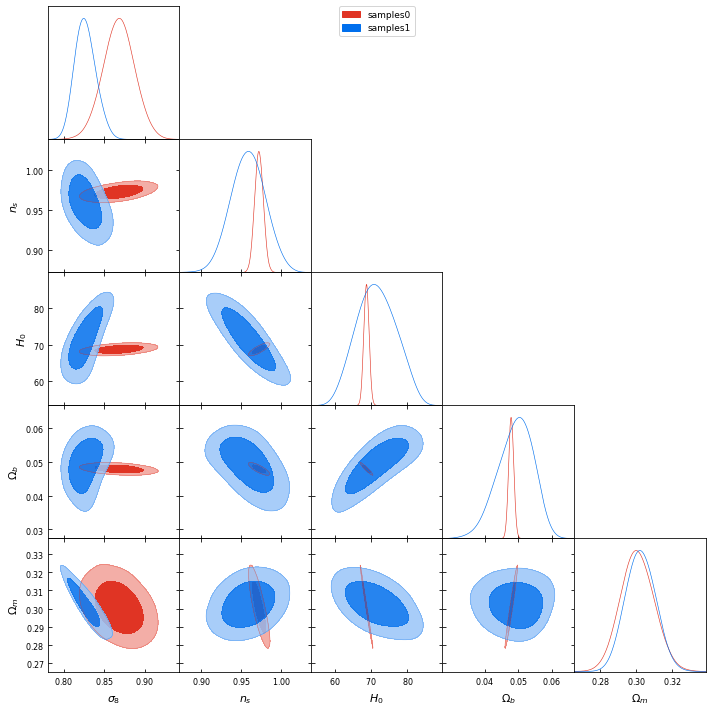

In [22]:
# reparameterize
names = ['sigma8','ns','H0','omegab','omegam']
labels = ['\sigma_8','n_s','H_0','\Omega_b','\Omega_m']

rel_params1 = chain1.samples[:,[5,4,2,0,1]]
re_chain1 = getdist.mcsamples.MCSamples(samples=emu_to_params(rel_params1),names=names,labels=labels)
re_chain2 = getdist.mcsamples.MCSamples(samples=emu_to_params(chain2.samples),names=names,labels=labels)

g.triangle_plot([re_chain1,re_chain2], params=['sigma8','ns','H0','omegab','omegam'], filled=True)

In [26]:
### get the variances
# sigma8
planck_var_s8 = re_chain1.cov(['sigma8'])[0][0]
lsst_var_s8   = re_chain2.cov(['sigma8'])[0][0]
var_sigma8 = np.sqrt(planck_var_s8**2 + lsst_var_s8**2)
print(var_sigma8)

# omega_m
planck_var_omm = re_chain1.cov(['omegam'])[0][0]
lsst_var_omm   = re_chain2.cov(['omegam'])[0][0]
var_omm = np.sqrt(planck_var_omm**2 + lsst_var_omm**2)
print(var_omm)

# PC1 = 0.49ns + 0.3H0 - 0.82omegab
planck_var_ns = re_chain1.cov(['ns'])[0][0]
lsst_var_ns   = re_chain2.cov(['ns'])[0][0]

planck_var_h0 = re_chain1.cov(['H0'])[0][0]
lsst_var_h0   = re_chain2.cov(['H0'])[0][0]

planck_var_ob = re_chain1.cov(['omegab'])[0][0]
lsst_var_ob   = re_chain2.cov(['omegab'])[0][0]

var_ns = np.sqrt(planck_var_ns**2 + lsst_var_ns**2)
var_h0 = np.sqrt(planck_var_h0**2 + lsst_var_h0**2)
var_ob = np.sqrt(planck_var_ob**2 + lsst_var_ob**2)
print(var_ns)
print(var_h0)
print(var_ob)

0.00042632336409059214
0.00011374154455319452
0.0004702200526988948
29.620915011730023
2.810083489926335e-05


In [33]:
# reparameterize truth
cosmo_truth = np.array([[3.0675, 0.97, 69., 0.0228528, 0.1199772]])
re_truth = emu_to_params(cosmo_truth)[0]
print(re_truth)

[8.25018076e-01 9.70000000e-01 6.90000000e+01 4.80000000e-02
 3.01354628e-01]


In [44]:
# start with shifts in sigma 8
for i in [-3,-2,-1,1,2,3]:
    params = re_truth - i*var_sigma8*np.array([1.,0.,0.,0.,0.]) # shift sigma8
    cosmo_params = list(params_to_emu(np.array([params])))         # convert to emu params
    cosmo_params.append( [0., 0., 0., 0., 0.,
                      0.5, 0.,
                      0., 0., 0., 0., 0.,
                      1.24, 1.36, 1.47, 1.60, 1.76,
                      0., 0., 0., 0., 0.,
                      0., 0.,1.05,0.05,1.0])               # add systematics
    cosmo_params = [item for sublist in cosmo_params for item in sublist] # concatenate
    dv = get_data_vector_emu(np.array(cosmo_params))      #get datavector
    
    #sampling dist
    noise_dist = torch.distributions.multivariate_normal.MultivariateNormal(
        loc=torch.Tensor(dv), covariance_matrix=cov)
    
    data_set = np.array([noise_dist.sample()[0].numpy() for i in range(1000)])
    print(data_set.shape)
    np.savetxt('/home/grads/data/evan/shift_sigma8_'+str(i)+'.txt',data_set)

(1000, 1560)
(1000, 1560)
(1000, 1560)
(1000, 1560)
(1000, 1560)
(1000, 1560)


In [48]:
# shift omegam
for i in [-3,-2,-1,1,2,3]:
    params = re_truth - i*var_omm*np.array([0.,0.,0.,0.,1.]) # shift omegam
    cosmo_params = list(params_to_emu(np.array([params])))         # convert to emu params
    cosmo_params.append( [0., 0., 0., 0., 0.,
                      0.5, 0.,
                      0., 0., 0., 0., 0.,
                      1.24, 1.36, 1.47, 1.60, 1.76,
                      0., 0., 0., 0., 0.,
                      0., 0.,1.05,0.05,1.0])               # add systematics
    cosmo_params = [item for sublist in cosmo_params for item in sublist] # concatenate
    dv = get_data_vector_emu(np.array(cosmo_params))      #get datavector
    
    #sampling dist
    noise_dist = torch.distributions.multivariate_normal.MultivariateNormal(
        loc=torch.Tensor(dv), covariance_matrix=cov)
    
    data_set = np.array([noise_dist.sample()[0].numpy() for i in range(1000)])
    print(data_set.shape)
    np.savetxt('/home/grads/data/evan/shift_omegam_'+str(i)+'.txt',data_set)

(1000, 1560)
(1000, 1560)
(1000, 1560)
(1000, 1560)
(1000, 1560)
(1000, 1560)


In [47]:
# shift PC1
# PC1 = 0.49ns + 0.3H0 - 0.82omegab
for i in [-3,-2,-1,1,2,3]:
    params = re_truth - i*np.array([0,0.49,0.3,-0.82,0])*np.array([0.,var_ns,var_h0,var_ob,0.]) # shift omegam
    cosmo_params = list(params_to_emu(np.array([params])))         # convert to emu params
    cosmo_params.append( [0., 0., 0., 0., 0.,
                      0.5, 0.,
                      0., 0., 0., 0., 0.,
                      1.24, 1.36, 1.47, 1.60, 1.76,
                      0., 0., 0., 0., 0.,
                      0., 0.,1.05,0.05,1.0])               # add systematics
    cosmo_params = [item for sublist in cosmo_params for item in sublist] # concatenate
    dv = get_data_vector_emu(np.array(cosmo_params))      #get datavector
    
    #sampling dist
    noise_dist = torch.distributions.multivariate_normal.MultivariateNormal(
        loc=torch.Tensor(dv), covariance_matrix=cov)
    
    data_set = np.array([noise_dist.sample()[0].numpy() for i in range(1000)])
    print(data_set.shape)
    np.savetxt('/home/grads/data/evan/shift_pc1_'+str(i)+'.txt',data_set)

(1000, 1560)
(1000, 1560)
(1000, 1560)
(1000, 1560)
(1000, 1560)
(1000, 1560)


## Testing
Now test how the emulator performs for large shifts

In [85]:
# Sample from the prior
# Cosmo params have hard prior
cosmo_prior_lim = np.array([[1.61, 3.91],# planck [1.61,  3.91,  'uniform'],
                       [0.87, 1.07], # planck [0.9,   1.1,   'uniform']
                       [55, 91],
                       [0.01, 0.04], # [0.001, 0.04, 'uniform'],
                       [0.001, 0.99]]) # [0.005, 0.99,  'uniform'],

logAs = np.random.uniform(1.61, 3.91,1000000)
ns = np.random.uniform(0.87,1.07,1000000)
H0 = np.random.uniform(55,91,1000000)
omegab  = np.random.uniform(0.01,0.04,1000000)
omegac  = np.random.uniform(0.001,0.99,1000000)
samples = np.transpose([logAs,ns,H0,omegab,omegac])
print(samples)

[[2.31158246e+00 8.72816981e-01 5.93817172e+01 1.67281435e-02
  5.38656664e-01]
 [1.69170911e+00 1.05920500e+00 7.14483915e+01 2.72344301e-02
  7.05642762e-01]
 [3.50990160e+00 8.80121184e-01 7.49151915e+01 2.45985447e-02
  8.80512359e-01]
 ...
 [2.60716480e+00 9.79397752e-01 6.11126982e+01 1.97486139e-02
  3.90218797e-01]
 [2.90023074e+00 9.95188536e-01 8.21467746e+01 1.53400919e-02
  5.95390273e-01]
 [2.33076469e+00 9.82065984e-01 8.40840745e+01 3.76476472e-02
  6.71349109e-02]]


In [89]:
# generate shifts in $\sigma_8$
var = re_chain.cov(['sigma8'])[0][0]
print(var)
stdev = np.sqrt(var)
re_truth = truth_converted[0]
vals = []


params = re_truth - 5*stdev*np.array([1.,0.,0.,0.,0.]) # shift     
cosmo_params = list(params_to_emu(np.array([params])))         # convert to emu params
cosmo_params.append( [0., 0., 0., 0., 0.,
                  0.5, 0.,
                  0., 0., 0., 0., 0.,
                  1.24, 1.36, 1.47, 1.60, 1.76,
                  0., 0., 0., 0., 0.,
                  0., 0.,1.05,0.05,1.0])               # add systematics
cosmo_params = [item for sublist in cosmo_params for item in sublist] # concatenate
dv = get_data_vector_emu(np.array(cosmo_params))      #get datavector
vals.append(params[0])
print('log_lkl={:.5f}, shift={}sigma, sigma8={:.5f}'.format(-2*ln_lkl(np.array(cosmo_params)),(5),params[0]))



# now lets sample
shifted_samples = []
data_model.dv_obs = dv[0]
emu_sampler = None
with Pool(10) as pool:
    emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
    emu_sampler.run_mcmc(pos0, 10000, progress=True)
_samples = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))
_s = _samples[...,:5]
shifted_samples.append(_s)

0.0001800948788278319
log_lkl=-0.00000, shift=5sigma, sigma8=0.75792


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [12:12<00:00, 13.65it/s]


Removed no burn in
Removed no burn in


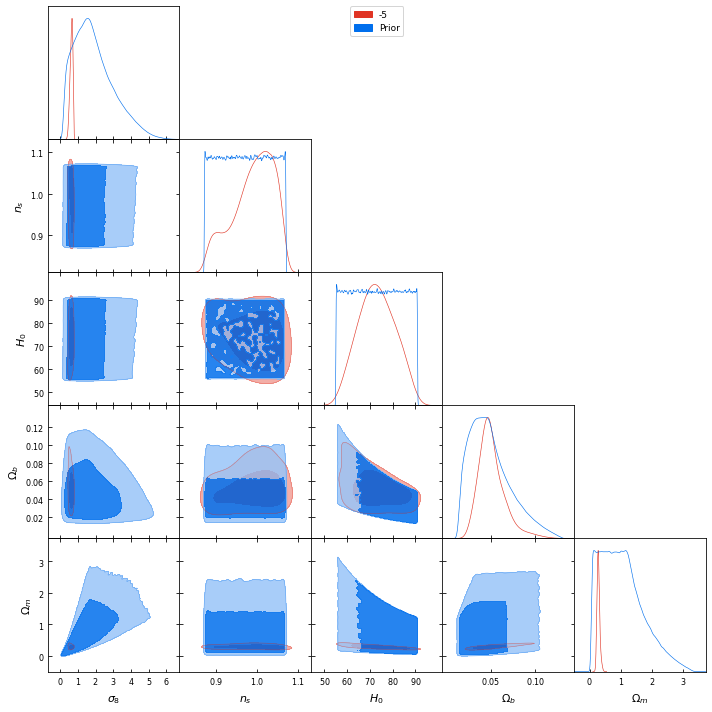

In [90]:
def plot_cosmo_contours(sample_list, legend_labels):
    names = ['sigma8','ns','H0','Omegab','omegam']
    labels = ['\sigma_8','n_s','H_0','\Omega_b','\Omega_m']
        
    getdist_samples = []
    for samples, legend_label in zip(sample_list, legend_labels):
        cosmo_samples = emu_to_params(samples[:,:5])
        getdist_samples.append(MCSamples(samples=cosmo_samples,names = names, labels=labels, label=legend_label))
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(getdist_samples, filled=True)#, markers=truth_dict)

plot_cosmo_contours([_samples,samples],
                    ['-5','Prior'])

Removed no burn in
Removed no burn in


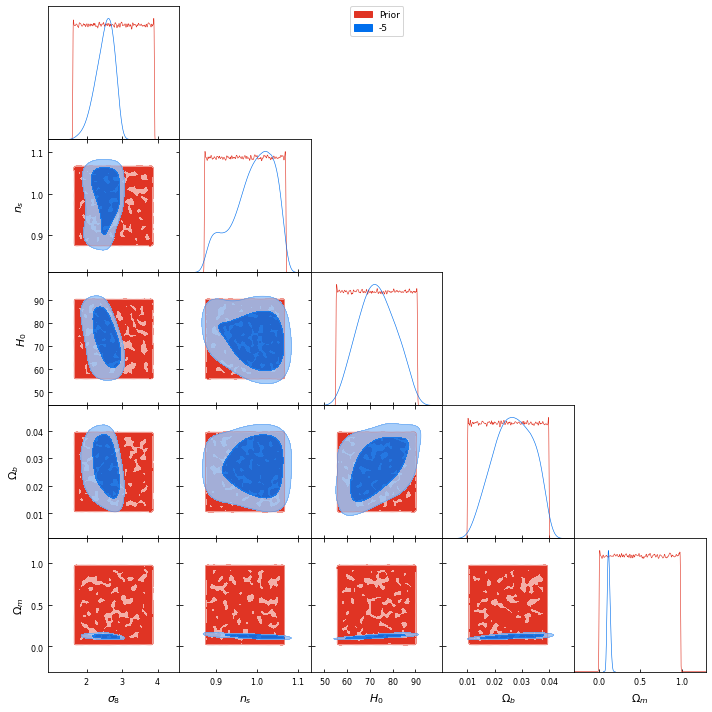

In [93]:
def plot_cosmo_contours(sample_list, legend_labels):
    names = ['sigma8','ns','H0','Omegab','omegam']
    labels = ['\sigma_8','n_s','H_0','\Omega_b','\Omega_m']
        
    getdist_samples = []
    for samples, legend_label in zip(sample_list, legend_labels):
        cosmo_samples = samples[:,:5]
        getdist_samples.append(MCSamples(samples=cosmo_samples,names = names, labels=labels, label=legend_label))
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(getdist_samples, filled=True)#, markers=truth_dict)

plot_cosmo_contours([samples,_samples],
                    ['Prior','-5'])